In [8]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


import src

In [20]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.17.1
Num GPUs Available:  1


In [9]:
paths, labels = src.data.extract_data()

Number of images:  16970
Attributes:  ['id', 'width', 'height', 'file_name', 'license', 'flickr_url', 'coco_url', 'date_captured']

Number of annotations (they refer to images): 16970
Attributes:  ['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd', 'attributes']

IDs don't always match!
17011 != 17000
Size of paths and labels should be the same:  16970 16970 0


Trenutno ne garantiram da ce podklase biti tocno raspoređene po datasetovima. To možda nije bitno za normalni model.

In [7]:
from sklearn.model_selection import train_test_split

train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    paths, 
    labels, 
    test_size=0.2, 
    random_state=42, 
    shuffle=True,
    stratify=labels  # Keeps class distribution balanced
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, 
    train_val_labels, 
    test_size=0.25, 
    random_state=42, 
    shuffle=True,
    stratify=train_val_labels
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Testing samples: {len(test_paths)}")

Training samples: 10182
Validation samples: 3394
Testing samples: 3394


In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [25]:
def load_and_preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    #img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, (512,512))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def create_dataset(paths, labels, is_for_training = False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if is_for_training:
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    ds = ds.batch(32).prefetch(tf.data.AUTOTUNE)
    return ds

In [26]:
train_ds = create_dataset(train_paths, train_labels, is_for_training=True)
val_ds = create_dataset(val_paths, val_labels)
test_ds = create_dataset(test_paths, test_labels)

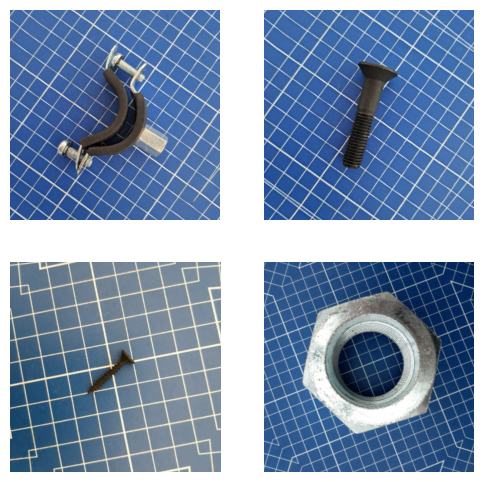

In [27]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(6,6))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
    plt.show()